# Using MarkovModels.jl

This notebook shows how to use the [MarkovModels.jl](https://github.com/lucasondel/MarkovModels.jl) package to compute the forward-backward algorithm. 
This is down in three steps:
1. creating the inference graph, i.e. the markov chain of the model
2. compiling the graph into a suitable format
3. running the forward-backward algorithm


In [2]:
using Pkg
Pkg.activate("../")

using MarkovModels
using Plots
using SparseArrays

## Inference graph

The first thing is to define the computation type. MarkovModels.jl does its computation in the logarithmic semifield and we have to specify the floating point precision:

In [3]:
T = Float64
SF = LogSemifield{T} 

LogSemifield{Float64}

Now, we create the inference graph:

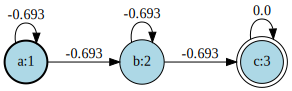

In [4]:
fsm = FSM{SF}()
S = 3 # Number of states

labels = ["a", "b", "c"]

prev = addstate!(fsm, pdfindex = 1, label = labels[1])
link!(fsm, prev, prev)
setinit!(prev)
for s in 2:S
    state = addstate!(fsm, pdfindex = s, label = "$(labels[s])")
    link!(fsm, prev, state)
    link!(fsm, state, state)
    prev = state
end
setfinal!(prev)

fsm |> renormalize!

## Compilation

The second step is to compile the graph, to put it in an inference-easy format. Notice that by default, the vector/matrices are sparse. If you want to use dense matrices use `compile(fsm, allocator = zeros)`

In [5]:
cfsm = compile(fsm)

(π =   [1]  =  0.0, ω =   [3]  =  0.0, A = 
 -0.693147  -0.693147        ⋅  
       ⋅    -0.693147  -0.693147
       ⋅          ⋅          0.0, Aᵀ = 
 -0.693147        ⋅     ⋅  
 -0.693147  -0.693147   ⋅  
       ⋅    -0.693147   0.0, dists = [2, 1, 0], pdfmap = [1, 2, 3])

Just for information, the compiled graph `cfsm` has, among others, the following attributes:
* `cfsm.π` log-probability of the initial state
* `cfsm.ω` log-probability of the final state
* `cfsm.A` log-probability of the state transitions

However, you don't need to use them directly in most cases.

## Forward-Backward algorithm
 
For the sake of the example, we simulate some pseudo-loglikelihood:

In [6]:
S = length(cfsm.π) # number of states
N = 10 # number of frames
lhs = convert(Matrix{SF}, randn(T, S, N))

3×10 Matrix{LogSemifield{Float64}}:
  0.570085  -1.42999   -0.56121  0.583718  …  0.562504  -0.341756   1.45486
 -0.119464   1.73092   -2.91286  -1.38121      1.64174  -0.944021  0.501052
  0.112404   0.15022  -0.635746   1.35409     -1.02931  -0.762198   1.95681

Notice that the matrix of log-likelihood has to be in the log-semifield!!

Now to compute the forward-backward algorithm we just have to do:

In [7]:
lnγ, ttl = αβrecursion(cfsm, lhs)

(
  0.0  -0.0113461  -0.0159049  -0.0674642  …   -7.33219        ⋅     ⋅  
  ⋅      -4.48454    -4.21603    -2.75051     -0.960939   -2.12845   ⋅  
  ⋅           ⋅      -6.88605    -6.61225      -0.48319  -0.126723   0.0, 2.951408587230645)

where `lnγ` is a matrix of log-probability and `ttl` is the total log-probability of sequence.

To get the probability we need to convert `lnγ` to the natural semifield and take the element-wise exponential: 

In [8]:
γ = exp.(convert(Matrix{T}, lnγ))

3×10 Matrix{Float64}:
 1.0  0.988718  0.984221    0.934761    …  0.00065414  0.0       0.0
 0.0  0.011282  0.0147571   0.063895       0.382533    0.119022  0.0
 0.0  0.0       0.00102194  0.00134381     0.616812    0.880978  1.0

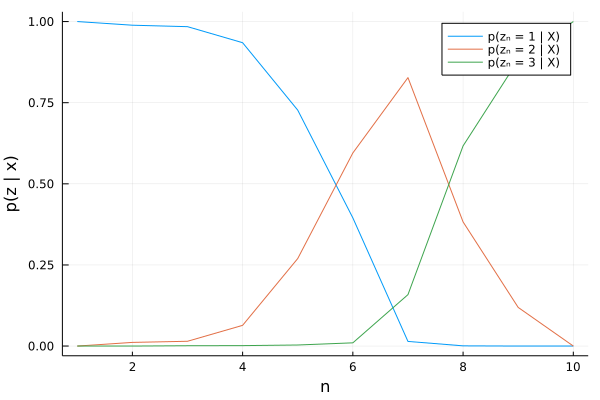

In [9]:
p = plot(xlabel = "n", ylabel = "p(z | x)")
for s in 1:S
    plot!(p, γ[s, :], label = "p(zₙ = $s | X)")
end
p

# FSM Operations
- `replace(fsm, subfsms)` - replace all states of `fsm` with label `l` with FSM `subfsms[l]` 
- `union(fsm1, fsm2, ...)` - merge `fsm1` and `fsm2` into single FSM, i.e. it deos FSM summation

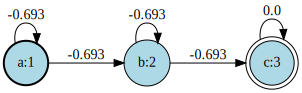

In [10]:
fsm1 = fsm

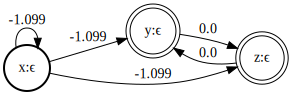

In [11]:
fsm2 = FSM()
sx = addstate!(fsm2, label = "x")
sy = addstate!(fsm2, label = "y")
sz = addstate!(fsm2, label = "z")
link!(fsm2, sx, sx)
link!(fsm2, sx, sy)
link!(fsm2, sx, sz)
link!(fsm2, sy, sz)
link!(fsm2, sz, sy)
setinit!(sx)
setfinal!(sy)
setfinal!(sz)
fsm2 = renormalize!(fsm2)

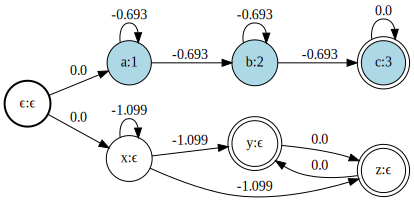

In [12]:
unionfsm = union(fsm, fsm2)

In [13]:
import MarkovModels: isinit, isfinal
filter(isinit, unionfsm.states)

1-element Vector{MarkovModels.State{LogSemifield{Float64}}}:
 MarkovModels.State{LogSemifield{Float64}}(1, 0.0, -Inf, nothing, nothing)

In [14]:
filter(isfinal, unionfsm.states)

3-element Vector{MarkovModels.State{LogSemifield{Float64}}}:
 MarkovModels.State{LogSemifield{Float64}}(4, -Inf, 0.0, 3, "c")
 MarkovModels.State{LogSemifield{Float64}}(6, -Inf, -0.6931471805599453, nothing, "y")
 MarkovModels.State{LogSemifield{Float64}}(7, -Inf, -0.6931471805599453, nothing, "z")

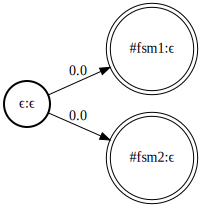

In [15]:
fsm = FSM{SF}()
s = addstate!(fsm)
s1 = addstate!(fsm, label = "#fsm1")
s2 = addstate!(fsm, label = "#fsm2")
link!(fsm, s, s1)
link!(fsm, s, s2)
setinit!(s)
setfinal!(s1)
setfinal!(s2)
fsm

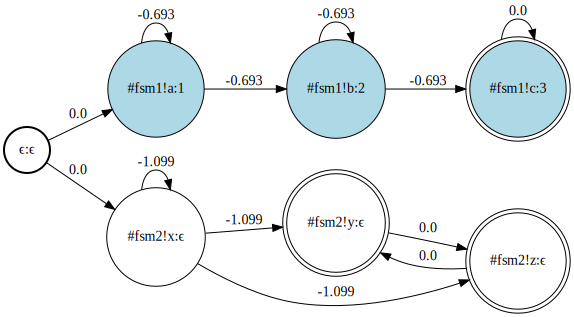

In [16]:
unionfsm = replace(fsm, Dict("#fsm1" => fsm1, "#fsm2" => fsm2))

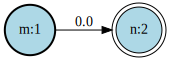

In [17]:
fsm3 = FSM{SF}()
sm = addstate!(fsm3, pdfindex=1, label="m")
sn = addstate!(fsm3, pdfindex=2, label="n")
link!(fsm3, sm, sn)
setinit!(sm)
setfinal!(sn)
fsm3

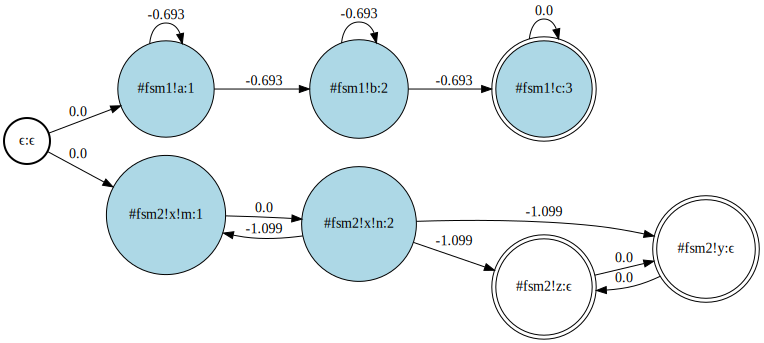

In [18]:
replace(unionfsm, Dict("x" => fsm3))

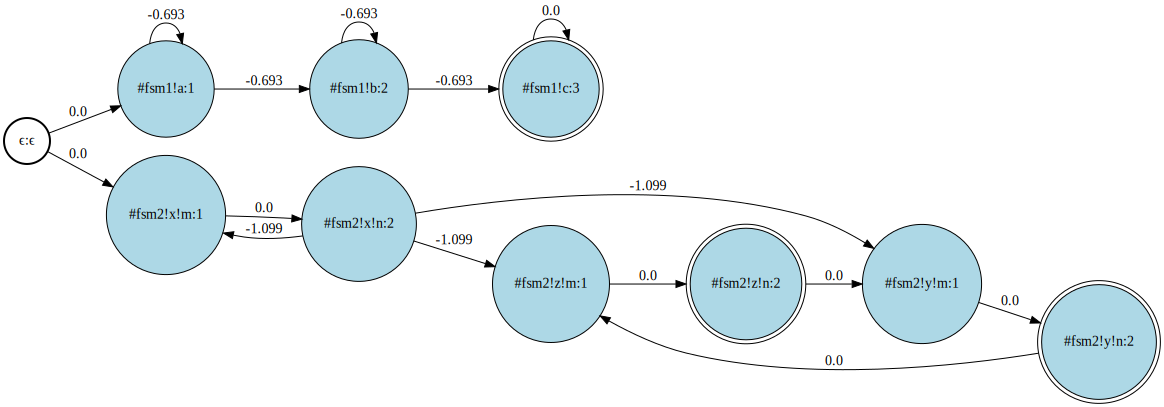

In [21]:
replace(unionfsm, Dict("#fsm2" => fsm3); matching_func=first)

LoadError: UndefVarError: void not defined